<h1>Time series analysis on the price of crude oil<h1>
<h3>We shall start by drawing a line chart in order to determine if the series shows seasonality or trend.<h3>

          DATE  COprice
250 2015-11-01    43.11
251 2015-12-01    36.57
252 2016-01-01    29.78
253 2016-02-01    31.03
254 2016-03-01    37.34
..         ...      ...
308 2020-09-01    40.60
309 2020-10-01    39.90
310 2020-11-01    42.30
311 2020-12-01    48.73
312 2021-01-01    53.60

[63 rows x 2 columns]


<function matplotlib.pyplot.show(close=None, block=None)>

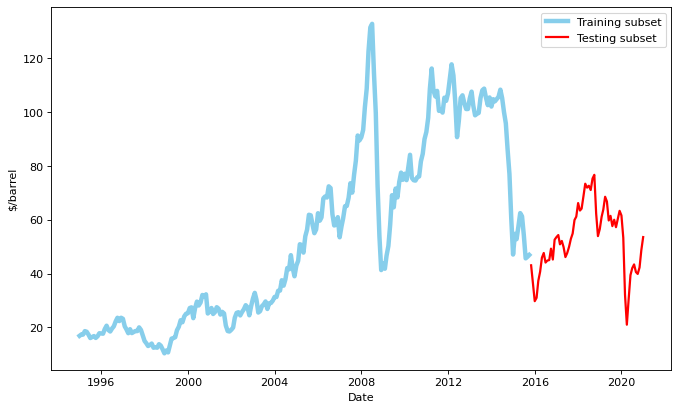

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from matplotlib import pyplot
from matplotlib.pyplot import figure
import pandas as pd
from pprint import pprint

from sklearn.model_selection import train_test_split
path = "\Data\CrudeOil.csv" #input path to data
df = pd.read_csv(path)
df["COprice"] = pd.to_numeric(df.COprice, errors = 'coerce')

df["DATE"] = pd.to_datetime(df['DATE'])
#df = df.iloc[287:]
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)
print(X_test)

figure(figsize=(10,6), dpi=80)
pyplot.tight_layout()
pyplot.locator_params(axis='x',tight = True, nbins=10)

pyplot.plot( 'DATE', "COprice", data=X_train, marker='', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=4)
pyplot.plot( 'DATE','COprice', data=X_test, marker='', color='red', linewidth=2)
pyplot.ylabel("$/barrel")
pyplot.xlabel("Date")
pyplot.legend(["Training subset", "Testing subset"], loc ="upper right")


#pyplot.xticks(rotation=-60)

pyplot.show



<h3>From the chart we can tell that the series has both a trend and significant seasonality. We also see that it's non-stationary regarding its mean and not its variance. <h3>
<blockquote>In order to better understand the stationarity of the series, the autocorrelation and partial autocorrelation charts are drawn.<blockquote>

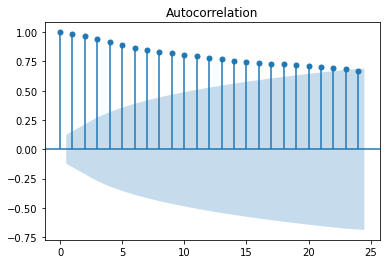

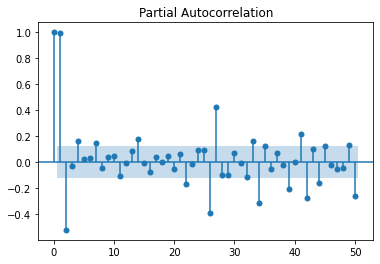

In [3]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(X_train["COprice"])
plot_pacf(X_train["COprice"], lags=50)
pyplot.show()

<h3> We see that the series is non-stationary and that it displays seasonality, the autocorrelation coefficient decreasing slowly.<h3>
<blockquote>We use the Augmented Dickey-Fuller Test in order to verify if the series is indeed non-stationary. <blockquote>

In [4]:
from statsmodels.tsa.stattools import adfuller

X= X_train["COprice"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.948862
p-value: 0.309435
Critical values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


<h2>The results of the Augmented Dickey-Fuller Test show that the p-value is 0.31, thus not rejecting the null hypothesis which states that the series is non-stationary.<h2>
<blockquote> After the previous analyses we can safely conclude that the series is non-stationary and in order to stationarize it we must differentiate it to the 1st and 2nd order. <blockquote>

<h3> First order differencing. 

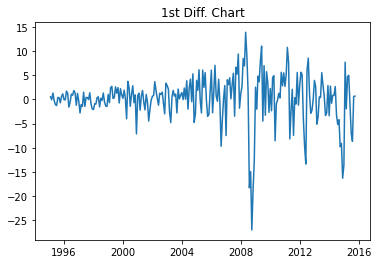

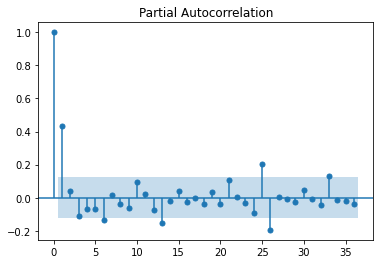

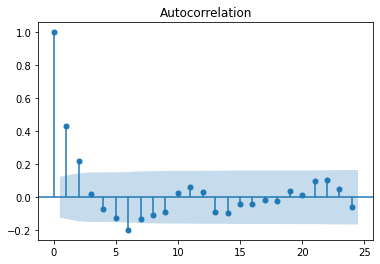

In [5]:
diff=X_train["COprice"].diff()
pyplot.plot(X_train['DATE'],diff)
pyplot.title("1st Diff. Chart")
pyplot.show()
Y = diff.dropna()


plot_pacf(Y, lags=36)
plot_acf(Y)
pyplot.show()

<h3> We see from the differenced series' line chart that the trend seems to have disappeared, thus the series looking like it's stationary. In order to confirm this supposition, we will take a look at the autocorrelation chart. It also shows us that the series is stationary as the autocorrelation coefficient is rapidly decreasing starting with the first lag. <h3>

<blockquote>In order to draw a final conclusion on the series' stationarity, we shall run the Augmented Dickey-Fuller Test on it.<blockquote>


In [6]:
result2 = adfuller(Y)
print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])
print('Critical values:')
for key, value in result2[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.885865
p-value: 0.000000
Critical values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


<h3> The Augmented Dickey-Fuller test shows a p-value of 0, thus offering us enough proof that the series is indeed stationary. <h3>

<blockquote> We will now 2nd degree differentiate the time series in order to have as much data as possible to choose from when building the models. <blockquote>
 

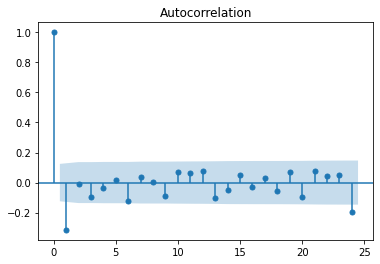

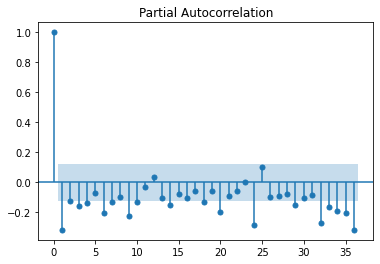

ADF Statistic: -9.885865
p-value: 0.000000
Critical values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [7]:
diff2 = Y.diff()
Z=diff2.dropna()
result3 = adfuller(Y)
plot_acf(Z)
plot_pacf(Z, lags=36)
pyplot.show()
print('ADF Statistic: %f' % result3[0])
print('p-value: %f' % result3[1])
print('Critical values:')
for key, value in result3[4].items():
	print('\t%s: %.3f' % (key, value))

<h3> We see that the series is still stationary and that we can use it in building SARIMA models<h3>


<h2> Next we will begin creating the SARIMA models <h2>

<h3> We will begin with the SARIMA models based on the first degree differencing <h3>

<blockquote> First SARIMA model will be SARIMA(1,1,1)x(1,1,1,12) <blockquote>


                                     SARIMAX Results                                      
Dep. Variable:                            COprice   No. Observations:                  250
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -704.563
Date:                            Mon, 16 Aug 2021   AIC                           1421.126
Time:                                    11:55:17   BIC                           1441.934
Sample:                                         0   HQIC                          1429.513
                                            - 250                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0207      0.043     -0.487      0.627      -0.104       0.063
ar.L1          0.4895      0.096   

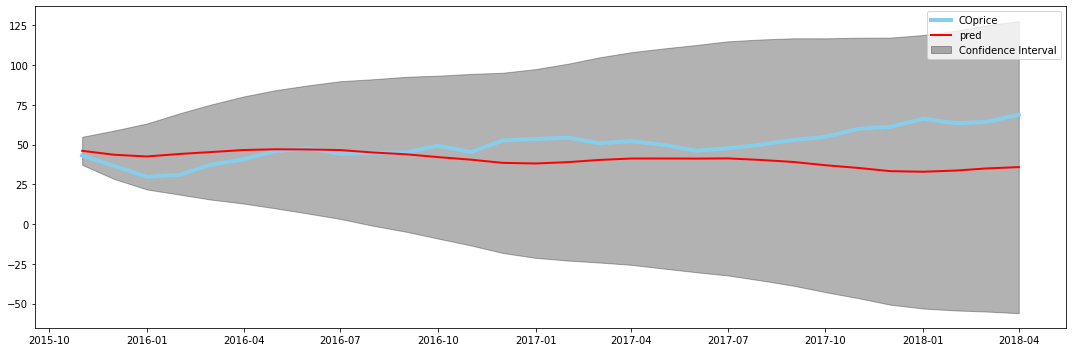

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import durbin_watson

model = SARIMAX(X_train['COprice'], order=(1,1,1),seasonal_order=(1,1,1,12), trend='c')
model_fit = model.fit()
#df['forecast'] = model_fit.predict(exog =1,typ='levels')
print(model_fit.summary())
#print(model_fit.summary2())
print(" Durbin-Watson Test value: ",durbin_watson(model_fit.resid)) #Durbin-Watson

ax = pyplot.subplots(figsize=(15, 5))
fcast = model_fit.get_forecast(steps = 30).summary_frame()
X_test['pred'] = fcast['mean']
X_test['lower'] = fcast['mean_ci_lower']
X_test['upper'] = fcast['mean_ci_upper']

A = np.identity(len(model_fit.params))
A=A[1:,:]
Fvalue = model_fit.f_test(A) #testul F
print("F-Test value: ",Fvalue)
X_test = X_test.dropna()
#print(X_test)

pyplot.plot( 'DATE', "COprice", data=X_test, marker='', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=4)
pyplot.plot( 'DATE', 'pred', data=X_test, marker='', color='red', linewidth=2)
pyplot.fill_between(X_test['DATE'],X_test['upper'], X_test['lower'], color='k', alpha=0.3, label = 'Confidence Interval')
pyplot.tight_layout()
#pyplot.xticks(rotation=-60)


pyplot.legend()


pyplot.show()

We note from the SARIMA output that this model has relevant only: ar.L1, however, the Ljung-Box test has a probability of 0.97, which means that the null hypothesis that the data series is not white noise will be accepted and the process can be modeled.<br> The Durbin-Watson test has a value of 1.95, thus indicating that the model shows no significant autocorrelation of residuals, and the F-test indicates that the model is valid. <br>
We have also carried out the 30-month forecast for the test data. We note that although the point prediction remains close to the true value, the confidence interval for the 95% probability becomes so large that any prediction going beyond the first 8 observations (June 2016) can be considered redundant.<br>
A final point to note is the Akaike (AIC) information criterion values of 1421.126, Schwarz (BIC) of 1441.934 and Hannan (HQIC) of 1429.513. These values are not meaningful by themselves but will be useful in determining the superior model.


<h3> Now for the SARIMA(2,1,2) model

Q:\Python\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                            COprice   No. Observations:                  250
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -698.987
Date:                            Mon, 16 Aug 2021   AIC                           1417.975
Time:                                    11:55:24   BIC                           1452.655
Sample:                                         0   HQIC                          1431.953
                                            - 250                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0019      0.004     -0.518      0.604      -0.009       0.005
ar.L1          1.5373      0.091   

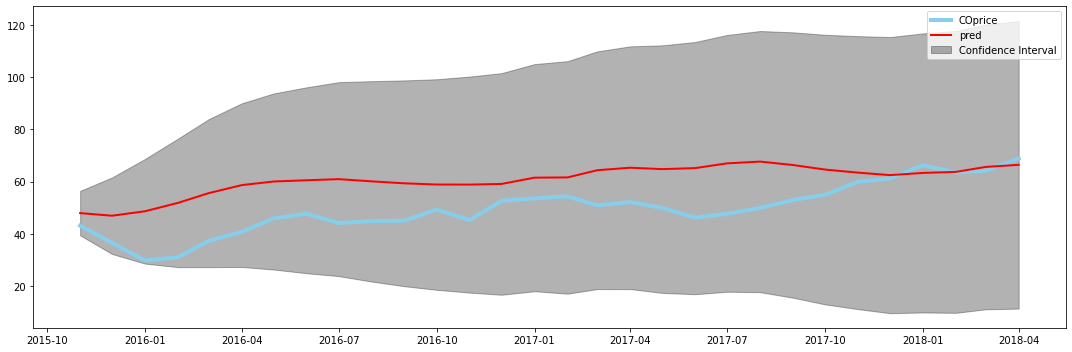

In [9]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import durbin_watson

model = SARIMAX(X_train['COprice'], order=(2,1,2),seasonal_order=(2,1,2,12), trend='c')
model_fit = model.fit()
#df['forecast'] = model_fit.predict(exog =1,typ='levels')
print(model_fit.summary())
#print(model_fit.summary2())


ax = pyplot.subplots(figsize=(15, 5))
fcast = model_fit.get_forecast(steps = 30).summary_frame()
X_test['pred'] = fcast['mean']
X_test['lower'] = fcast['mean_ci_lower']
X_test['upper'] = fcast['mean_ci_upper']

print(" Durbin-Watson Test value: ",durbin_watson(model_fit.resid)) #Durbin-Watson

A = np.identity(len(model_fit.params))
A=A[1:,:]
Fvalue = model_fit.f_test(A) #testul F
print("F-Test value: ",Fvalue)

X_test = X_test.dropna()
#print(X_test)

pyplot.plot( 'DATE', "COprice", data=X_test, marker='', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=4)
pyplot.plot( 'DATE', 'pred', data=X_test, marker='', color='red', linewidth=2)
pyplot.fill_between(X_test['DATE'],X_test['upper'], X_test['lower'], color='k', alpha=0.3, label = 'Confidence Interval')
pyplot.tight_layout()
#pyplot.xticks(rotation=-60)


pyplot.legend()


pyplot.show()






We note from the SARIMA output that this model only has relevant components: ar.L1, ar.L2, ma.L2, ar.S.L24, ma.S.L12 and the $sigma^2$ component, however, the Ljung-Box test has a probability of 0.95, which means that the null hypothesis that the data series is not white noise will be accepted and the process can be modeled. <br> The Durbin-Watson test has a value of 1.95, slightly better than the previous model, thus indicating that the model has no significant autocorrelation of residuals, and the F-test indicates that the model is valid. <br>
We have also carried out the 30-month forecast for the test data. We note that although the point prediction remains close to the true value, the confidence interval for the 95% probability becomes so large that any prediction going beyond the first 8 observations (June 2016) can be considered redundant.<br>
Another thing to point out is the Akaike information criterion (AIC) values of 1418, Schwarz (BIC) of 1452.68 and Hannan (HQIC) of 1431.978. These values are higher than those of the previous model, thus indicating that this would be an inferior model of the evolution of the price of a barrel of oil.

In [10]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf


def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1

    print("MAPE: {mape} \n ME: {me} \n MAE: {mae} \n MPE: {mpe} \n RMSE: {rmse}".format(mape = mape, me=me, mae=mae, mpe=mpe, rmse=rmse) )


forecast_accuracy(X_test['pred'], X_test['COprice'])

Residuals = []
for index, row in X_test.iterrows():
    Residuals.append(row['pred']-row['COprice'])
    
Reziduals = pd.Series(Residuals, name = "Residuals")







MAPE: 0.257875897771895 
 ME: 11.023016980163135 
 MAE: 11.375955964773135 
 MPE: 0.25263574134136524 
 RMSE: 12.925101921833637
